Here we are going to compare whitened composites vs standard composites to see which create better images.

In [1]:
import os
import string
import re
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# Import your models
from mnist_skeptic_v9 import skeptic_v9  # Ensure this path is correct

class ModelEnsemble:
    def __init__(self, models):
        self.models = models
    
    def predict(self, x):
        predictions = [model(x) for model in self.models]
        return torch.stack(predictions).mean(dim=0)
    
    def eval(self):
        for model in self.models:
            model.eval()

In [3]:
def load_ensemble_models(model_class, folder_path, num_models=20, device='cpu'):
    """
    Load multiple models into an ensemble.
    
    Args:
        model_class (class): The class of the model to instantiate.
        folder_path (str): Path to the folder containing model checkpoints.
        num_models (int): Number of models to load.
        device (str): Device to load the models on ('cpu' or 'cuda').
        
    Returns:
        ModelEnsemble: An ensemble of loaded models.
    """
    models = []
    
    for idx, letter in enumerate(string.ascii_lowercase[:num_models]):
        model = model_class()
        checkpoint_path = os.path.join(folder_path, f'skeptic_v10_{letter}_finetuned.pth')
        
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Model checkpoint not found: {checkpoint_path}")
        
        state_dict = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        models.append(model)
        print(f"Loaded model {idx+1}/{num_models}: {checkpoint_path}")
    
    ensemble = ModelEnsemble(models)
    ensemble.eval()
    return ensemble

# Specify device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the ensemble
ensemble = load_ensemble_models(skeptic_v9, 'saved_models/skeptic_v10', num_models=20, device=device)

Loaded model 1/20: saved_models/skeptic_v10\skeptic_v10_a_finetuned.pth
Loaded model 2/20: saved_models/skeptic_v10\skeptic_v10_b_finetuned.pth
Loaded model 3/20: saved_models/skeptic_v10\skeptic_v10_c_finetuned.pth
Loaded model 4/20: saved_models/skeptic_v10\skeptic_v10_d_finetuned.pth
Loaded model 5/20: saved_models/skeptic_v10\skeptic_v10_e_finetuned.pth
Loaded model 6/20: saved_models/skeptic_v10\skeptic_v10_f_finetuned.pth
Loaded model 7/20: saved_models/skeptic_v10\skeptic_v10_g_finetuned.pth
Loaded model 8/20: saved_models/skeptic_v10\skeptic_v10_h_finetuned.pth
Loaded model 9/20: saved_models/skeptic_v10\skeptic_v10_i_finetuned.pth
Loaded model 10/20: saved_models/skeptic_v10\skeptic_v10_j_finetuned.pth
Loaded model 11/20: saved_models/skeptic_v10\skeptic_v10_k_finetuned.pth
Loaded model 12/20: saved_models/skeptic_v10\skeptic_v10_l_finetuned.pth
Loaded model 13/20: saved_models/skeptic_v10\skeptic_v10_m_finetuned.pth
Loaded model 14/20: saved_models/skeptic_v10\skeptic_v10_n_f

C:\Users\Sai\AppData\Local\Temp\ipykernel_116348\3947678960.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device

In [4]:
class ExperimentDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        """
        Initialize the dataset by loading image paths and corresponding labels.
        
        Args:
            folder_path (str): Path to the folder containing experiment images.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.folder_path = folder_path
        self.transform = transform
        self.data = []
        pattern = re.compile(r'(\d+)_trial_(\d+)_(\w+)_participant20\.png')
        
        for filename in os.listdir(folder_path):
            match = pattern.match(filename)
            if match:
                label, trial, condition = match.groups()
                label = int(label)
                trial = int(trial)
                condition = condition.lower()
                file_path = os.path.join(folder_path, filename)
                self.data.append((file_path, label, trial, condition))
            else:
                print(f"Filename does not match pattern and is skipped: {filename}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        file_path, label, trial, condition = self.data[idx]
        image = Image.open(file_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, label, trial, condition

In [27]:
# Define transformations (excluding normalization here; we'll handle it during composite creation)
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor()
])

# Initialize the dataset
dataset = ExperimentDataset('experiment_results_participant20', transform=transform)

# Organize data by label and condition, sorted by trial number
data_dict = defaultdict(lambda: defaultdict(list))

for img, label, trial, condition in dataset:
    data_dict[label][condition].append((trial, img))

# Sort the trials for each label and condition
for label in data_dict:
    for condition in data_dict[label]:
        data_dict[label][condition].sort(key=lambda x: x[0])

Filename does not match pattern and is skipped: 2_composite_standard_participant20.png
Filename does not match pattern and is skipped: 2_composite_whitened_participant20.png
Filename does not match pattern and is skipped: 4_composite_standard_participant20.png
Filename does not match pattern and is skipped: 4_composite_whitened_participant20.png
Filename does not match pattern and is skipped: 7_composite_standard_participant20.png
Filename does not match pattern and is skipped: 7_composite_whitened_participant20.png


In [28]:
def create_composite(images):
    """
    Create a composite image by averaging pixel values of the provided images.
    
    Args:
        images (list of tuples): List containing (trial_number, image_tensor).
        
    Returns:
        torch.Tensor: Composite image tensor with shape (1, 1, 16, 16).
    """
    # Extract image tensors
    image_tensors = [img for _, img in images]
    
    # Stack images to form (N, 1, 16, 16)
    stacked_images = torch.stack(image_tensors, dim=0)  # Shape: (N, 1, 16, 16)
    
    # Compute pixel-wise average
    composite = torch.mean(stacked_images, dim=0)  # Shape: (1, 16, 16)
    
    # Normalize based on min-max scaling
    min_val = composite.min()
    max_val = composite.max()
    
    if max_val - min_val > 0:
        composite_normalized = (composite - min_val) / (max_val - min_val)
    else:
        composite_normalized = torch.zeros_like(composite)  # Handle edge case
    
    # Scale to [0, 255] for visualization consistency
    composite_normalized = composite_normalized * 255
    
    # Add batch and channel dimensions
    composite_normalized = composite_normalized.unsqueeze(0)  # Shape: (1, 1, 16, 16)
    
    return composite_normalized

In [29]:
def compare_composites(python_composite_path, js_composite_path):
    """
    Compare two composite images to ensure they are identical or within an acceptable difference.
    
    Args:
        python_composite_path (str): Path to the composite image created in Python.
        js_composite_path (str): Path to the composite image created in JSPsych.
        
    Returns:
        bool: True if images are similar within a threshold, False otherwise.
    """
    python_img = Image.open(python_composite_path).convert('L')
    js_img = Image.open(js_composite_path).convert('L')
    
    python_array = np.array(python_img).astype(np.float32)
    js_array = np.array(js_img).astype(np.float32)
    
    # Compute absolute difference
    diff = np.abs(python_array - js_array)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)
    
    print(f"Max Difference: {max_diff}, Mean Difference: {mean_diff}")
    
    # Define a threshold for similarity (e.g., max_diff <= 1)
    threshold = 1  # Adjust as needed based on normalization precision
    return max_diff <= threshold

# Specify the trials and corresponding JS composite images
sanity_trials = [
    (2, 'standard'),
    (2, 'whitened'),
    (4, 'standard'),
    (4, 'whitened'),
    (7, 'standard'),
    (7, 'whitened')
]

# Perform the sanity check
for trial_num, condition in sanity_trials:
    label = trial_num  # Assuming label corresponds to the digit; adjust if necessary
    # Adjust if label is actually specified differently
    # For example, if label != trial_num, retrieve the correct label
    # Here, assuming you have separate digits; adjust accordingly
    
    # Find corresponding digit; assuming trial_num relates to digit 2,4,7
    digits_to_check = [2, 4, 7]
    if trial_num not in digits_to_check:
        continue  # Skip if not one of the digits to check
    
    # Load the first 'trial_num' images for the digit and condition
    # Assuming trial_num corresponds to the number of images to average
    images = data_dict[trial_num][condition][:trial_num]  # Adjust if label != trial_num
    
    # Create composite
    composite = create_composite(images).cpu()
    
    # Save the Python composite for comparison
    python_composite_path = f'composite_python_{trial_num}_{condition}_participant20.png'
    # Denormalize for saving
    composite_to_save = (composite.squeeze() * 255).byte()
    composite_pil = Image.fromarray(composite_to_save.numpy(), mode='L')
    composite_pil.save(python_composite_path)
    
    # Define the path to the corresponding JSPsych composite
    js_composite_path = f'experiment_results_participant20/{trial_num}_composite_{condition}_participant20.png'  # Adjust filename as needed
    
    # Check if JSPsych composite exists
    if not os.path.exists(js_composite_path):
        print(f"JSPsych composite not found: {js_composite_path}. Skipping comparison.")
        continue
    
    # Compare the composites
    similarity = compare_composites(python_composite_path, js_composite_path)
    if similarity:
        print(f"Composite match successful for trial {trial_num}, condition '{condition}'.")
    else:
        print(f"Composite mismatch for trial {trial_num}, condition '{condition}'.")

Max Difference: 207.0, Mean Difference: 69.12890625
Composite mismatch for trial 2, condition 'standard'.
Max Difference: 222.0, Mean Difference: 69.02734375
Composite mismatch for trial 2, condition 'whitened'.
Max Difference: 254.0, Mean Difference: 68.35546875
Composite mismatch for trial 4, condition 'standard'.
Max Difference: 245.0, Mean Difference: 70.8984375
Composite mismatch for trial 4, condition 'whitened'.
Max Difference: 190.0, Mean Difference: 70.85546875
Composite mismatch for trial 7, condition 'standard'.
Max Difference: 241.0, Mean Difference: 68.671875
Composite mismatch for trial 7, condition 'whitened'.


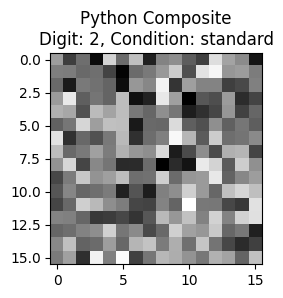

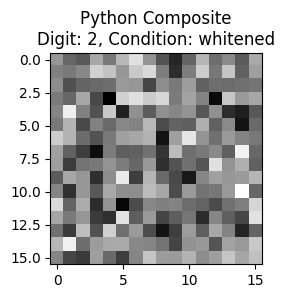

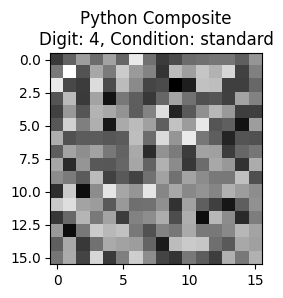

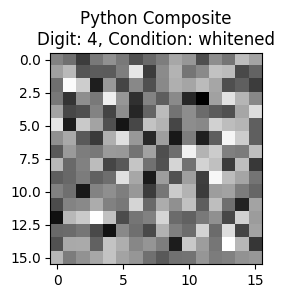

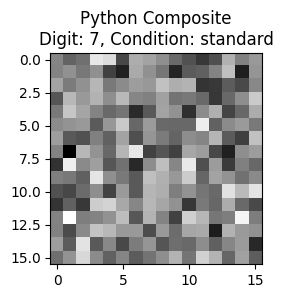

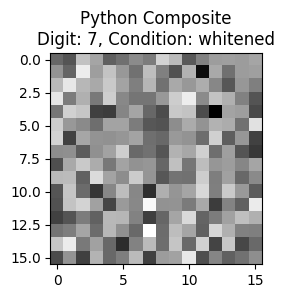

In [30]:
def visualize_composite(images, trial_num, label, condition):
    """
    Visualizes the composite image at a specific trial.
    
    Args:
        images (list of tuples): List containing (trial_number, image_tensor).
        trial_num (int): The trial number to visualize.
        label (int): The true label of the digit.
        condition (str): The condition ('standard' or 'whitened').
    """
    composite = create_composite(images[:trial_num]).cpu().squeeze().numpy()
    
    plt.figure(figsize=(6, 3))
    
    plt.subplot(1, 2, 1)
    plt.imshow(composite.astype(np.uint8), cmap='gray')
    plt.title(f'Python Composite\nDigit: {label}, Condition: {condition}')
    
    js_composite_path = f'{trial_num}_composite_{condition}_participant20.png'
    
    if os.path.exists(js_composite_path):
        js_img = Image.open(js_composite_path).convert('L')
        plt.subplot(1, 2, 2)
        plt.imshow(js_img, cmap='gray')
        plt.title(f'JSPsych Composite\nDigit: {label}, Condition: {condition}')
    
    plt.show()

# Example usage for sanity check trials
sanity_trials = [
    (2, 'standard'),
    (2, 'whitened'),
    (4, 'standard'),
    (4, 'whitened'),
    (7, 'standard'),
    (7, 'whitened')
]

for trial_num, condition in sanity_trials:
    if trial_num in data_dict and condition in data_dict[trial_num]:
        visualize_composite(data_dict[trial_num][condition], trial_num, trial_num, condition)

In [31]:
# Define trial intervals
trial_intervals = list(range(1, 101, 10))  # [1, 11, 21, ..., 91]

# Initialize a list to store classification results
classification_results = []

# Iterate over each digit and condition
for label in sorted(data_dict.keys()):
    for condition in data_dict[label]:
        images = data_dict[label][condition]
        total_images = len(images)
        
        print(f"\nProcessing Digit: {label}, Condition: '{condition}', Total Images: {total_images}")
        
        for trial in trial_intervals:
            if trial > total_images:
                print(f"--> Trial {trial} exceeds available images ({total_images}). Skipping.")
                continue
            
            # Create composite with the first 'trial' images
            composite = create_composite(images[:trial]).to(device)
            
            # Predict using the ensemble
            with torch.no_grad():
                output = ensemble.predict(composite)
                pred = output.argmax(dim=1).item()
                confidence = F.softmax(output, dim=1)[0][pred].item()
            
            # Append the result to the list
            classification_results.append({
                'Digit': label,
                'Condition': condition,
                'Trial': trial,
                'Predicted_Label': pred,
                'Confidence': confidence
            })
            
            print(f"--> Trial {trial}: Predicted = {pred}, True = {label}, Confidence = {confidence:.4f}")

# Convert results to a DataFrame
results_df = pd.DataFrame(classification_results)

# Pivot the DataFrame to have trials as columns
pivot_df = results_df.pivot_table(index=['Digit', 'Condition'],
                                  columns='Trial',
                                  values='Predicted_Label').reset_index()

# Optional: Rename columns for clarity
pivot_df.columns.name = None
trial_columns = [f'Trial_{t}' for t in trial_intervals]
pivot_df.columns = ['Digit', 'Condition'] + trial_columns

# Display the table
print("\nClassification Results Table:")
display(pivot_df)

# Save the table to a CSV file
pivot_df.to_csv('classification_results_table.csv', index=False)
print("Classification results saved to 'classification_results_table.csv'.")


Processing Digit: 2, Condition: 'standard', Total Images: 100
--> Trial 1: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 11: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 21: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 31: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 41: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 51: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 61: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 71: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 81: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 91: Predicted = 1, True = 2, Confidence = 1.0000

Processing Digit: 2, Condition: 'whitened', Total Images: 100
--> Trial 1: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 11: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 21: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 31: Predicted = 1, True = 2, Confidence = 1.0000
--> Trial 41: Predicted = 1, True = 2, Confidence 

,Digit,Condition,Trial_1,Trial_11,Trial_21,Trial_31,Trial_41,Trial_51,Trial_61,Trial_71,Trial_81,Trial_91
0,2,standard,1,1,1,1,1,1,1,1,1,1
1,2,whitened,1,1,1,1,1,1,1,1,1,1
2,4,standard,1,1,1,1,1,1,1,1,1,1
3,4,whitened,1,1,1,1,1,1,1,1,1,1
4,7,standard,1,1,1,1,1,1,1,1,1,1
5,7,whitened,1,1,1,1,1,1,1,1,1,1


Classification results saved to 'classification_results_table.csv'.


In [32]:
# Separate DataFrames for Predictions and Confidence
pred_df = results_df.pivot_table(index=['Digit', 'Condition'],
                                 columns='Trial',
                                 values='Predicted_Label').reset_index()

conf_df = results_df.pivot_table(index=['Digit', 'Condition'],
                                 columns='Trial',
                                 values='Confidence').reset_index()

# Rename columns
pred_columns = [f'Pred_Trial_{t}' for t in trial_intervals]
conf_columns = [f'Conf_Trial_{t}' for t in trial_intervals]

pred_df.columns = ['Digit', 'Condition'] + pred_columns
conf_df.columns = ['Digit', 'Condition'] + conf_columns

# Merge Predictions and Confidence
final_df = pd.merge(pred_df, conf_df, on=['Digit', 'Condition'])

# Display the final table
print("\nClassification Results with Confidence Scores:")
display(final_df)

# Save the final table to a CSV file
final_df.to_csv('classification_results_with_confidence.csv', index=False)
print("Detailed classification results saved to 'classification_results_with_confidence.csv'.")


Classification Results with Confidence Scores:


,Digit,Condition,Pred_Trial_1,Pred_Trial_11,Pred_Trial_21,Pred_Trial_31,Pred_Trial_41,Pred_Trial_51,Pred_Trial_61,Pred_Trial_71,...,Conf_Trial_1,Conf_Trial_11,Conf_Trial_21,Conf_Trial_31,Conf_Trial_41,Conf_Trial_51,Conf_Trial_61,Conf_Trial_71,Conf_Trial_81,Conf_Trial_91
0,2,standard,1,1,1,1,1,1,1,1,...,1.0,1.0,1.0,1.000000,0.999992,1.00000,0.999999,1.000000,1.000000,0.999999
1,2,whitened,1,1,1,1,1,1,1,1,...,1.0,1.0,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
2,4,standard,1,1,1,1,1,1,1,1,...,1.0,1.0,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
3,4,whitened,1,1,1,1,1,1,1,1,...,1.0,1.0,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
4,7,standard,1,1,1,1,1,1,1,1,...,1.0,1.0,1.0,0.999999,1.000000,0.99999,0.999997,0.999999,0.999941,0.999918
5,7,whitened,1,1,1,1,1,1,1,1,...,1.0,1.0,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


Detailed classification results saved to 'classification_results_with_confidence.csv'.


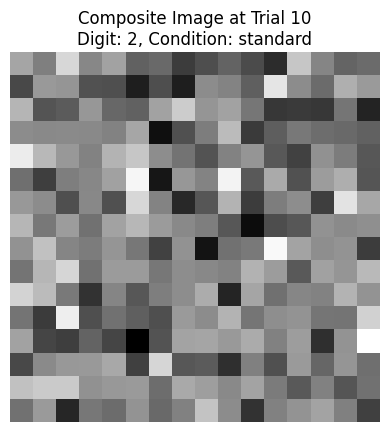

In [11]:
def visualize_composite(images, trial, label, condition):
    """
    Visualizes the composite image at a specific trial.
    
    Args:
        images (list of tuples): List containing (trial_number, image_tensor).
        trial (int): The trial number to visualize.
        label (int): The true label of the digit.
        condition (str): The condition ('standard' or 'whitened').
    """
    composite = create_composite(images[:trial]).cpu().squeeze().numpy()
    composite = (composite * 255).astype(np.uint8)  # De-normalize to [0, 255]
    
    plt.imshow(composite, cmap='gray')
    plt.title(f'Composite Image at Trial {trial}\nDigit: {label}, Condition: {condition}')
    plt.axis('off')
    plt.show()

# Example usage: Visualize composite at trial 10 for digit 2, 'standard' condition
digit_to_visualize = 2
condition_to_visualize = 'standard'
trial_to_visualize = 10

if digit_to_visualize in data_dict and condition_to_visualize in data_dict[digit_to_visualize]:
    images_sample = data_dict[digit_to_visualize][condition_to_visualize]
    if trial_to_visualize <= len(images_sample):
        visualize_composite(images_sample, trial_to_visualize, digit_to_visualize, condition_to_visualize)
    else:
        print(f"Not enough images for digit {digit_to_visualize}, condition '{condition_to_visualize}' to visualize trial {trial_to_visualize}.")

In [16]:
def create_composite(images):
    """
    Create a composite image by averaging pixel values of the provided images.
    
    Args:
        images (list of tuples): List containing (trial_number, image_tensor).
        
    Returns:
        torch.Tensor: Composite image tensor with shape (1, 1, 16, 16).
    """
    # Extract image tensors
    image_tensors = [img for _, img in images]
    
    # Stack images to form (N, 1, 16, 16)
    stacked_images = torch.stack(image_tensors, dim=0)  # Shape: (N, 1, 16, 16)
    
    # Compute pixel-wise average
    composite = torch.mean(stacked_images, dim=0)  # Shape: (1, 16, 16)
    
    # Normalize based on min-max scaling
    min_val = composite.min()
    max_val = composite.max()
    
    if max_val - min_val > 0:
        composite_normalized = (composite - min_val) / (max_val - min_val)
    else:
        composite_normalized = torch.zeros_like(composite)  # Handle edge case
    
    # Scale to [0, 255] for visualization consistency
    composite_normalized = composite_normalized * 255
    
    # Add batch and channel dimensions
    composite_normalized = composite_normalized.unsqueeze(0)  # Shape: (1, 1, 16, 16)
    
    return composite_normalized

In [17]:
def test_model_predictions(ensemble, data_dict):
    """
    Test model predictions on standard and whitened conditions.
    
    Args:
        ensemble (ModelEnsemble): The ensemble of models.
        data_dict (dict): Dictionary of images organized by label and condition.
        
    Returns:
        None
    """
    device = next(ensemble.models[0].parameters()).device
    
    for label in sorted(data_dict.keys()):
        for condition in data_dict[label]:
            images = data_dict[label][condition]
            total_images = len(images)
            
            print(f"\nTesting Digit: {label}, Condition: '{condition}', Total Images: {total_images}")
            
            # Create a composite of all available images
            composite = create_composite(images).to(device)
            
            # Predict using the ensemble
            with torch.no_grad():
                output = ensemble.predict(composite)
                pred = output.argmax(dim=1).item()
                confidence = F.softmax(output, dim=1)[0][pred].item()
            
            print(f"Predicted Label: {pred}, True Label: {label}, Confidence: {confidence:.4f}")

# Test predictions on all conditions
test_model_predictions(ensemble, data_dict)


Testing Digit: 2, Condition: 'standard', Total Images: 100
Predicted Label: 1, True Label: 2, Confidence: 1.0000

Testing Digit: 2, Condition: 'whitened', Total Images: 100
Predicted Label: 1, True Label: 2, Confidence: 1.0000

Testing Digit: 4, Condition: 'standard', Total Images: 100
Predicted Label: 1, True Label: 4, Confidence: 1.0000

Testing Digit: 4, Condition: 'whitened', Total Images: 100
Predicted Label: 1, True Label: 4, Confidence: 1.0000

Testing Digit: 7, Condition: 'standard', Total Images: 100
Predicted Label: 1, True Label: 7, Confidence: 0.9997

Testing Digit: 7, Condition: 'whitened', Total Images: 100
Predicted Label: 1, True Label: 7, Confidence: 1.0000


In [22]:
def classify_single_image(ensemble, image_path):
    """
    Classify a single image using the ensemble model.
    
    Args:
        ensemble (ModelEnsemble): The ensemble of models.
        image_path (str): Path to the image file.
        
    Returns:
        None
    """
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    img = Image.open(image_path).convert('L')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = ensemble.predict(img_tensor)
        pred = output.argmax(dim=1).item()
        confidence = F.softmax(output, dim=1)[0][pred].item()
    
    print(f"Image Path: {image_path}, Predicted Label: {pred}, Confidence: {confidence:.4f}")

In [33]:
# Example usage for a specific image path
classify_single_image(ensemble, 'composite_python_2_standard_participant20.png')
classify_single_image(ensemble, 'composite_python_4_standard_participant20.png')
classify_single_image(ensemble, 'composite_python_7_standard_participant20.png')

classify_single_image(ensemble, 'composite_python_2_whitened_participant20.png')
classify_single_image(ensemble, 'composite_python_4_whitened_participant20.png')
classify_single_image(ensemble, 'composite_python_7_whitened_participant20.png')

Image Path: composite_python_2_standard_participant20.png, Predicted Label: 4, Confidence: 0.2084
Image Path: composite_python_4_standard_participant20.png, Predicted Label: 7, Confidence: 0.1730
Image Path: composite_python_7_standard_participant20.png, Predicted Label: 0, Confidence: 0.1149
Image Path: composite_python_2_whitened_participant20.png, Predicted Label: 0, Confidence: 0.1355
Image Path: composite_python_4_whitened_participant20.png, Predicted Label: 0, Confidence: 0.1384
Image Path: composite_python_7_whitened_participant20.png, Predicted Label: 7, Confidence: 0.1598


In [34]:
classify_single_image(ensemble, 'composite_python_two.png')
classify_single_image(ensemble, 'composite_python_four.png')
classify_single_image(ensemble, 'composite_python_seven.png')

Image Path: composite_python_two.png, Predicted Label: 2, Confidence: 0.1477
Image Path: composite_python_four.png, Predicted Label: 4, Confidence: 0.1464
Image Path: composite_python_seven.png, Predicted Label: 7, Confidence: 0.1123


My head hurts and I am tired, nothing is really making sense to me right now :(

In [38]:
def create_composite(images):
    """
    Create a composite image by averaging pixel values of the provided images
    and applying consistent normalization.

    Args:
        images (list of tuples): List containing (trial_number, image_tensor).

    Returns:
        torch.Tensor: Normalized composite image tensor with shape (1, 1, 16, 16).
    """
    # Extract image tensors
    image_tensors = [img for _, img in images]
    
    # Stack images to form (N, 1, 16, 16)
    stacked_images = torch.stack(image_tensors, dim=0)  # Shape: (N, 1, 16, 16)
    
    # Compute pixel-wise average
    composite = torch.mean(stacked_images, dim=0)  # Shape: (1, 16, 16)
    
    # Normalize using the same parameters as in classify_single_image
    composite = (composite - 0.5) / 0.5  # Equivalent to transforms.Normalize((0.5,), (0.5,))
    
    # Add batch dimension
    composite = composite.unsqueeze(0)  # Shape: (1, 1, 16, 16)
    
    return composite

In [39]:
def load_ensemble_models(model_class, folder_path, num_models=20, device='cpu'):
    """
    Load multiple models into an ensemble.

    Args:
        model_class (class): The class of the model to instantiate.
        folder_path (str): Path to the folder containing model checkpoints.
        num_models (int): Number of models to load.
        device (str): Device to load the models on ('cpu' or 'cuda').

    Returns:
        ModelEnsemble: An ensemble of loaded models.
    """
    models = []
    
    for idx, letter in enumerate(string.ascii_lowercase[:num_models]):
        model = model_class()
        checkpoint_path = os.path.join(folder_path, f'skeptic_v10_{letter}_finetuned.pth')
        
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Model checkpoint not found: {checkpoint_path}")
        
        state_dict = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        models.append(model)
        print(f"Loaded model {idx+1}/{num_models}: {checkpoint_path}")
    
    ensemble = ModelEnsemble(models)
    ensemble.eval()
    return ensemble

In [40]:
def test_model_predictions(ensemble, data_dict):
    """
    Test model predictions on standard and whitened conditions.

    Args:
        ensemble (ModelEnsemble): The ensemble of models.
        data_dict (dict): Dictionary of images organized by label and condition.

    Returns:
        None
    """
    device = next(ensemble.models[0].parameters()).device
    
    for label in sorted(data_dict.keys()):
        for condition in data_dict[label]:
            images = data_dict[label][condition]
            total_images = len(images)
            
            print(f"\nTesting Digit: {label}, Condition: '{condition}', Total Images: {total_images}")
            
            # Create a composite of all available images
            composite = create_composite(images).to(device)
            
            # Debug: Check composite tensor statistics
            print(f"Composite Tensor Statistics - Min: {composite.min().item()}, Max: {composite.max().item()}, Mean: {composite.mean().item()}")
            
            # Predict using the ensemble
            with torch.no_grad():
                output = ensemble.predict(composite)
                pred = output.argmax(dim=1).item()
                confidence = F.softmax(output, dim=1)[0][pred].item()
            
            print(f"Predicted Label: {pred}, True Label: {label}, Confidence: {confidence:.4f}")

In [41]:
# Test predictions on all conditions
test_model_predictions(ensemble, data_dict)


Testing Digit: 2, Condition: 'standard', Total Images: 100
Composite Tensor Statistics - Min: -0.09192156791687012, Max: 0.20894122123718262, Mean: 0.045239608734846115
Predicted Label: 9, True Label: 2, Confidence: 0.1039

Testing Digit: 2, Condition: 'whitened', Total Images: 100
Composite Tensor Statistics - Min: -0.1298823356628418, Max: 0.1685490608215332, Mean: 0.005205296445637941
Predicted Label: 8, True Label: 2, Confidence: 0.1041

Testing Digit: 4, Condition: 'standard', Total Images: 100
Composite Tensor Statistics - Min: -0.11952924728393555, Max: 0.20996081829071045, Mean: 0.04694825038313866
Predicted Label: 6, True Label: 4, Confidence: 0.1043

Testing Digit: 4, Condition: 'whitened', Total Images: 100
Composite Tensor Statistics - Min: -0.16549021005630493, Max: 0.1819608211517334, Mean: -0.0033863091375678778
Predicted Label: 6, True Label: 4, Confidence: 0.1046

Testing Digit: 7, Condition: 'standard', Total Images: 100
Composite Tensor Statistics - Min: -0.18290191

In [42]:
def classify_single_image(ensemble, image_path):
    """
    Classify a single image using the ensemble model.

    Args:
        ensemble (ModelEnsemble): The ensemble of models.
        image_path (str): Path to the image file.

    Returns:
        None
    """
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    img = Image.open(image_path).convert('L')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = ensemble.predict(img_tensor)
        pred = output.argmax(dim=1).item()
        confidence = F.softmax(output, dim=1)[0][pred].item()
    
    print(f"Image Path: {image_path}, Predicted Label: {pred}, Confidence: {confidence:.4f}")

In [43]:
def save_composite_image(composite_tensor, filename):
    """
    Save a composite tensor as a PNG image.

    Args:
        composite_tensor (torch.Tensor): Composite image tensor with shape (1, 1, 16, 16).
        filename (str): Filename to save the image as.

    Returns:
        None
    """
    # De-normalize the tensor for visualization
    composite_denorm = (composite_tensor.squeeze().cpu() * 0.5) + 0.5  # Reverse normalization
    composite_denorm = composite_denorm.clamp(0, 1)  # Ensure values are within [0,1]
    composite_np = (composite_denorm.numpy() * 255).astype(np.uint8)  # Scale to [0,255]
    
    composite_img = Image.fromarray(composite_np, mode='L')
    composite_img.save(filename)
    print(f"Composite image saved as {filename}")

In [44]:
def detailed_test(ensemble, data_dict):
    """
    Perform a detailed test comparing batch and single image predictions.

    Args:
        ensemble (ModelEnsemble): The ensemble of models.
        data_dict (dict): Dictionary of images organized by label and condition.

    Returns:
        None
    """
    device = next(ensemble.models[0].parameters()).device
    
    for label in sorted(data_dict.keys()):
        for condition in data_dict[label]:
            images = data_dict[label][condition]
            total_images = len(images)
            
            print(f"\nTesting Digit: {label}, Condition: '{condition}', Total Images: {total_images}")
            
            # Create a composite of all available images
            composite = create_composite(images).to(device)
            
            # Save the composite for inspection
            composite_filename = f'composite_python_{label}_{condition}_participant20.png'
            save_composite_image(composite, composite_filename)
            
            # Batch Prediction
            with torch.no_grad():
                output = ensemble.predict(composite)
                pred_batch = output.argmax(dim=1).item()
                confidence_batch = F.softmax(output, dim=1)[0][pred_batch].item()
            
            print(f"Batch Prediction - Predicted Label: {pred_batch}, Confidence: {confidence_batch:.4f}")
            
            # Single Image Prediction (using the saved composite)
            classify_single_image(ensemble, composite_filename)

In [45]:
# Perform the detailed test
detailed_test(ensemble, data_dict)


Testing Digit: 2, Condition: 'standard', Total Images: 100
Composite image saved as composite_python_2_standard_participant20.png
Batch Prediction - Predicted Label: 9, Confidence: 0.1039
Image Path: composite_python_2_standard_participant20.png, Predicted Label: 9, Confidence: 0.1039

Testing Digit: 2, Condition: 'whitened', Total Images: 100
Composite image saved as composite_python_2_whitened_participant20.png
Batch Prediction - Predicted Label: 8, Confidence: 0.1041
Image Path: composite_python_2_whitened_participant20.png, Predicted Label: 8, Confidence: 0.1041

Testing Digit: 4, Condition: 'standard', Total Images: 100
Composite image saved as composite_python_4_standard_participant20.png
Batch Prediction - Predicted Label: 6, Confidence: 0.1043
Image Path: composite_python_4_standard_participant20.png, Predicted Label: 6, Confidence: 0.1043

Testing Digit: 4, Condition: 'whitened', Total Images: 100
Composite image saved as composite_python_4_whitened_participant20.png
Batch Pr